In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import ops
from keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np

2025-10-31 12:09:21.011617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
INP_SIZE = (300, 300)
TARGET_SIZE = (150, 150)
INTERPOLATION = "bilinear"

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 5

In [3]:
train_ds, validation_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True,
)


def preprocess_dataset(image, label):
    image = ops.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    label = ops.one_hot(label, num_classes=2)
    return (image, label)


train_ds = (
    train_ds.shuffle(BATCH_SIZE * 100)
    .map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds.map(preprocess_dataset, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

I0000 00:00:1761908963.305383   30277 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x


def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

    # Note: user can change num_res_blocks to >1 also if needed


def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    inputs = layers.Input(shape=[None, None, 3])

    # First, perform naive resizing.
    naive_resize = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(x)

    # Residual passes.
    # First res_block will get bottleneck output as input
    x = res_block(bottleneck)
    # Remaining res_blocks will get previous res_block output as input
    for _ in range(num_res_blocks - 1):
        x = res_block(x)

    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return keras.Model(inputs, final_resize, name="learnable_resizer")


learnable_resizer = get_learnable_resizer()

2025-10-31 12:09:24.109267: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-31 12:09:24.853270: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


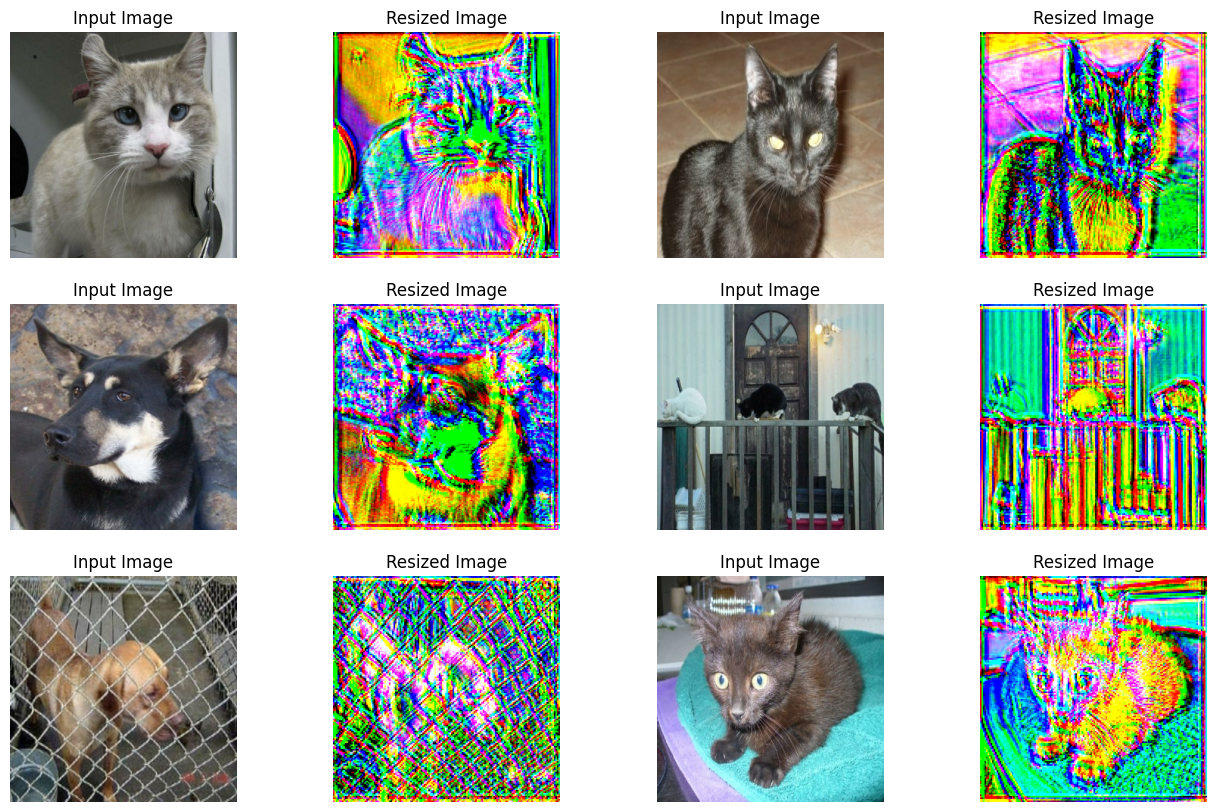

In [5]:
sample_images, _ = next(iter(train_ds))


plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")

In [6]:
def get_model():
    backbone = keras.applications.DenseNet121(
        weights=None,
        include_top=True,
        classes=2,
        input_shape=((TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    )
    backbone.trainable = True

    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = learnable_resizer(x)
    outputs = backbone(x)

    return keras.Model(inputs, outputs)

In [7]:
model = get_model()
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer="sgd",
    metrics=["accuracy"],
)
model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS)

Epoch 1/5


2025-10-31 12:09:38.542083: I external/local_xla/xla/service/service.cc:163] XLA service 0x72af040874b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 12:09:38.542135: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-31 12:09:39.126692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-31 12:09:43.476948: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:09:43.664891: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Syste

145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.5887 - loss: 0.6928

2025-10-31 12:11:19.521038: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:11:19.708652: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:11:20.251397: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:11:20.437579: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5888 - loss: 0.6926

2025-10-31 12:12:12.843946: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:12:13.030503: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:12:13.483497: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 12:12:13.666620: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


146/146 ━━━━━━━━━━━━━━━━━━━━ 173s 737ms/step - accuracy: 0.6052 - loss: 0.6739 - val_accuracy: 0.5052 - val_loss: 0.7054
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 341ms/step - accuracy: 0.6289 - loss: 0.6575 - val_accuracy: 0.5060 - val_loss: 0.7781
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 55s 376ms/step - accuracy: 0.6588 - loss: 0.6374 - val_accuracy: 0.5224 - val_loss: 0.8124
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 56s 381ms/step - accuracy: 0.6750 - loss: 0.6240 - val_accuracy: 0.5675 - val_loss: 0.7510
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 57s 385ms/step - accuracy: 0.7026 - loss: 0.5956 - val_accuracy: 0.5516 - val_loss: 0.9098


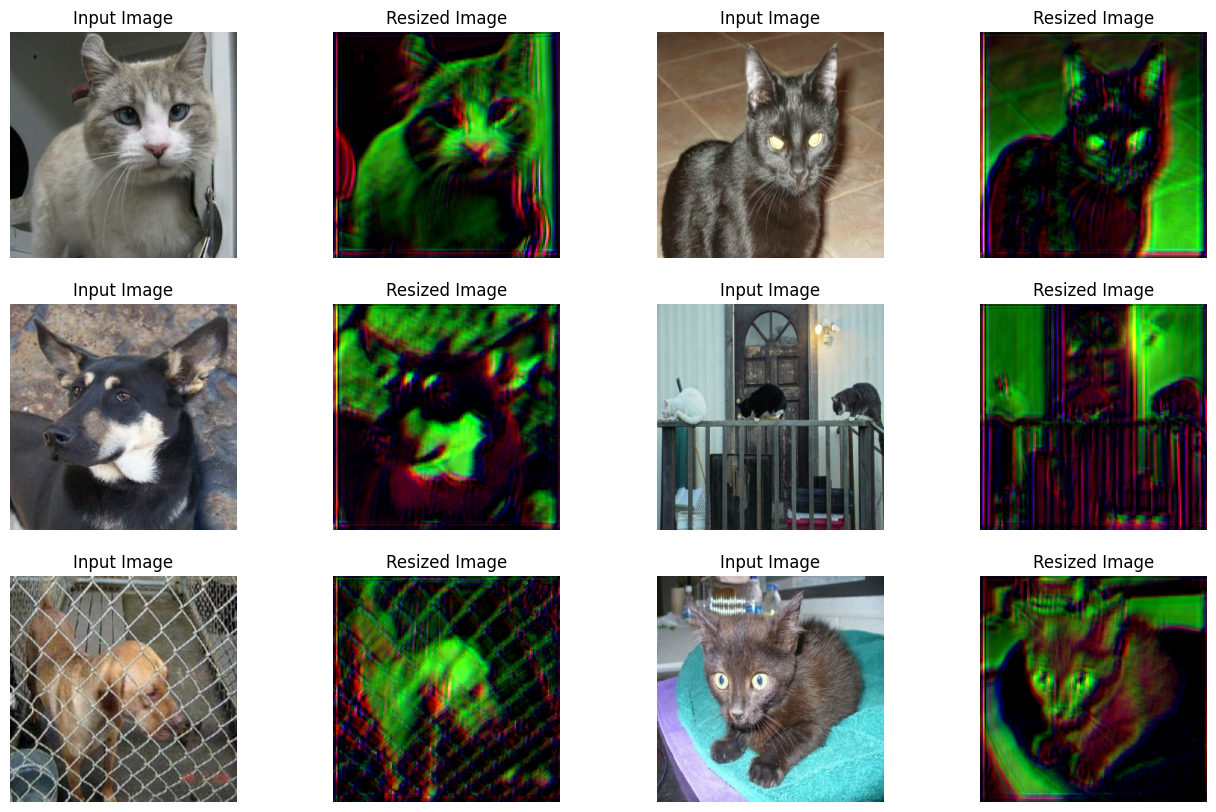

In [8]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze() / 10)
    plt.axis("off")